# 8.3 Lab: Decision Trees

## 8.3.1 Fitting Classification Trees

Demonstrate the fitting of decision trees for classification using the `Carseats` data set from the `ISLR` package. We will use the `statsmodels` library to load the R `data.frame` into a `pandas.core.frame.DataFrame` object.

We will use the `sklearn.tree` namespace and its associated classifers for [Decision Trees](https://scikit-learn.org/stable/modules/tree.html).

> Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.


In [1]:
from typing import List, Dict, Tuple, Sequence, Union
import sys

import statsmodels # root namespace for typing
import statsmodels.api as statsModels # alias to hide the extra api namespace

import numpy
import pandas 

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as pyplot

# custom support functions under libraries
sys.path.insert (0, "../../common-functions")
from DecisionTreeSummary import *

## Data Acquisition

In [2]:
# download the R data set as a pandas DataFrame
carSeatsDataSet = statsModels.datasets.get_rdataset ("Carseats", "ISLR")

# print out the help information on the data set to get the column documentation
print (carSeatsDataSet.__doc__)

+----------+-----------------+
| Carseats | R Documentation |
+----------+-----------------+

Sales of Child Car Seats
------------------------

Description
~~~~~~~~~~~

A simulated data set containing sales of child car seats at 400
different stores.

Usage
~~~~~

::

   Carseats

Format
~~~~~~

A data frame with 400 observations on the following 11 variables.

``Sales``
   Unit sales (in thousands) at each location

``CompPrice``
   Price charged by competitor at each location

``Income``
   Community income level (in thousands of dollars)

``Advertising``
   Local advertising budget for company at each location (in thousands
   of dollars)

``Population``
   Population size in region (in thousands)

``Price``
   Price company charges for car seats at each site

``ShelveLoc``
   A factor with levels ``Bad``, ``Good`` and ``Medium`` indicating the
   quality of the shelving location for the car seats at each site

``Age``
   Average age of the local population

``Education``
   Educat

## Data Adjustments

In the original dataset, the variable `Sales` is a continuous variable that represents the unit sales (in thousands) at each location. We need to convert that to a binary variable. In R, qualitative variables can be used directly, but in Python, we will need to use quantative values with 0 being low sales and 1 being high sales.

In addition, Python does not automatically encode qualitative variables and their levels. We must manually do that by one-hot encoding which will create a separate variable for each level with a value of 0 or 1. There are a couple of approaches outlined below. The first (commented out), is using an ordinal encoder to have the shelve location \[Bad, Medium, Good] be a single column with values \[0, 1, 2]. The second (implemented), is converting the "ShelveLoc" into 2 dummy variables and dropping the reference level for Bad. 

**R Code**
```R
library ("tree")
library ("ISLR")
attach (Carseats)
High = ifelse (Sales <= 8, "No", "Yes")

Carseats = data.frame (Carseats, High)
```

In [3]:
# Get the pandas DataFrame, use copy so that we can re-run from this point 
# and recover the original data set (non-referenced).
carSeatsDataFrame: pandas.core.frame.DataFrame = carSeatsDataSet.data.copy ()

# we will use the pandas get_dummies to create the dummy encodings that will also drop the 
# first level as the reference level and drop the original categorical variable
categoricalVariableNames = ["ShelveLoc", "Urban", "US"]
carSeatsDataFrame = pandas.get_dummies (carSeatsDataFrame, columns = categoricalVariableNames, drop_first = True)

# add a binary variable for high sales, note the reverse logic from the book
# and then the conversion of the dtype from boolean to int
carSeatsDataFrame["High"] = (carSeatsDataFrame ["Sales"] > 8)
carSeatsDataFrame["High"] = carSeatsDataFrame["High"].astype ("int32") 

# Let's preview the data set we have created and ensure that "High" is last and 
# "Sales" is first as we will subset with column index. 
carSeatsDataFrame.head ()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes,High
0,9.50,138,73,11,276,120,42,17,0,0,1,1,1
1,11.22,111,48,16,260,83,65,10,1,0,1,1,1
2,10.06,113,35,10,269,80,59,12,0,1,1,1,1
3,7.40,117,100,4,466,97,55,14,0,1,1,1,0
4,4.15,141,64,3,340,128,38,13,0,0,1,0,0


## Modeling

Fit the decision tree with all variables except for the original Sales variable which has been transformed into a binary. Now that we have created dummy variables for all the categorical levels, we can fit the model. 

** Note: The number of terminal nodes is being limited to the same found in the R model (27) so that the tree will be constrainted and not completely overfit the data. We are not splitting the data into train/test, yet.

**R Code**
```R
tree.carseats = tree (High ~ . - Sales, Carseats)
summary (tree.carseats)

plot (tree.carseats)
text (tree.carseats, pretty = 0)  # print category names
tree.carseats # print the tree structure
```

In [4]:
# slice the data frame into the X matrix and the y response vector 
X = carSeatsDataFrame.iloc [:, 1:-1] # skip sales in position 0 and High in last position
y = carSeatsDataFrame.loc [:, ["High"]]

# this is a full fit of the data like in the book with no split between training and test

# instatiate an instance of the sklearn.tree.DecisionTreeClassifier class
decisionTreeModel = DecisionTreeClassifier (max_leaf_nodes=27) # constrain leaf nodes to book
decisionTreeModel = decisionTreeModel.fit (X = X, y = y)

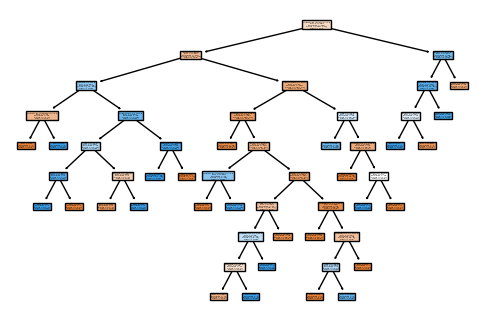

In [5]:

# we can get the tree structure as string 
treeAsText: str = sklearn.tree.export_text (decisionTreeModel, feature_names = X.columns.to_list ())

# or image using the standard built in plot_tree 
pyplot.subplots (nrows = 1, ncols = 1, figsize = (6, 4), dpi = 100)
ignore = sklearn.tree.plot_tree (decisionTreeModel, feature_names = X.columns.to_list (), class_names=["Low", "High"], filled = True)

# There are other visualization libraries like graphviz which require
# additional installations that can be managed by Anaconda. 
# sklearn.tree.export_graphviz ()

In [6]:
print (treeAsText)

|--- ShelveLoc_Good <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- ShelveLoc_Medium <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- ShelveLoc_Medium >  0.50
|   |   |   |   |--- class: 1
|   |   |--- Income >  57.00
|   |   |   |--- Population <= 207.50
|   |   |   |   |--- Age <= 56.50
|   |   |   |   |   |--- Price <= 88.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Price >  88.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Age >  56.50
|   |   |   |   |   |--- Income <= 102.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Income >  102.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- Population >  207.50
|   |   |   |   |--- Income <= 115.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Income >  115.00
|   |   |   |   |   |--- class: 0
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- CompPrice <= 124.50
|   |   |   |   |--- class: 0
|   |   |   |--- 

### Decision Tree Summary

In [7]:
decisionTreeNodes = DecisionTreeSummary (decisionTreeModel, X, y)

Classification tree: 
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=27,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Variables actually used in tree construction:
Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age',
       'ShelveLoc_Good', 'ShelveLoc_Medium'],
      dtype='object')
Number of terminal nodes: 27
Residual mean deviance: 5.4111 = 2018.35 / 373
Misclassification error rate: 0.07

Training Error Classification Report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       236
           1       0.93      0.90      0.91       164

    accuracy                           0.93       4

## Splitting the Data Set in Train/Test

Notice that the Python decision tree classifier will overfit to the training data if allowed, if you do not specify a max depth or max number of leaf nodes. The splits allow for no misclassifications because the allowed depth is not constrained. This is why it is important that we split the data into training and test data sets and/or use cross-validation in training. The next step is to split the data.

** Note: Again, we will constrained the maximum leaf nodes to the value that R used in its tree method (19) to keep the results approximately the same. Otherwise, the decision tree will perfectly fit the training set.

**R Code**
```R
set.seed (2)
train = sample (1:nrow (Carseats), 200)
Carseats.test = Carseats [-train, ]
High.test = High [-train]
tree.carseats = tree (High ~ . - Sales, CarseatsDF, subset = train)
tree.pred = predict(tree.carseats, Carseats.test, type = "class")
table (tree.pred, High.test)
```

In [8]:
# use the train test splitter to split randomly into data sets (50% each)
trainX, testX, trainy, testy = sklearn.model_selection.train_test_split (X, y, test_size = 0.50)

# set the seed for repeatable results
numpy.random.seed (2)

# instatiate an instance of the sklearn.tree.DecisionTreeClassifier class
decisionTreeModel = DecisionTreeClassifier (max_leaf_nodes = 19) # constrained to what R used
decisionTreeModel = decisionTreeModel.fit (X = trainX, y = trainy)

# create summary 
decisionTreeNodes = DecisionTreeSummary (decisionTreeModel, trainX, trainy, testX, testy)

Classification tree: 
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=19,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Variables actually used in tree construction:
Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age',
       'Education', 'ShelveLoc_Good', 'ShelveLoc_Medium'],
      dtype='object')
Number of terminal nodes: 19
Residual mean deviance: 5.2420 = 948.81 / 181
Misclassification error rate: 0.04

Test Error Classification Report
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       122
           1       0.64      0.78      0.70        78

    accuracy                           0.74

## Decision Trees with Cross-Validation

We will now use the training data set for cross-validation. In R, we take the fitted tree and use a specialized method that is from the same `tree` package. In Python, we can either create a k-fold set of data sets ourselves using the cross validation train test split (`sklearn.cross_validation.train_test_split`) or use the `sklearn.model_selection.GridSearchCV` to perform the split and fit the model. We will use the latter.

After using cross-validation to find the best model, we will use the best model and the test data set (with data the model has never seen) to get the test error rate. Finally, we will increase the tree size similar to how it was done in R and get that test error rate. 

Python uses the GridSearchCV and provides access to the `best_estimator_` property that contains the best fitted estimator. We do not have to "prune" the originally fit tree manually, but we will need to refit with a larger tree size at the end.

**R Code**
```R

set.seed (3)
cv.carseats = cv.tree (tree.carseats, FUN = prune.misclass)
names (cv.carseats)
cv.carseats

# plot the cross-validation metrics
# note: dev corresponds to the cross-validation error rate 
par (mfrow = c (1, 2))
plot (cv.carseats$size, cv.carseats$dev, type = "b") # size is depth
plot (cv.carseats$k, cv.carseats$dev, type = "b")    # k is complexity

# use the prune method to prune the tree to the best fit and plot 
prune.carseats = prune.misclass (tree.carseats, best = 9)
plot (prune.carseats)
text (prune.carseats, pretty = 0)

# predict the test set and show the confusion matrix 
tree.pred = predict (prune.carseats, Carseats.test, type = "class")
table (tree.pred, High.test)

# if we increase the best parameter, we can increase the number of 
# terminal nodes (larger tree) which will lower classification accuracy.
prune.carseats = prune.misclass (tree.carseats, best = 15)
plot (prune.carseats)
text (prune.carseats, pretty = 0)
tree.pred = predict (prune.carseats, Carseats.test, type = "class")
table (tree.pred, High.test)
```

In [9]:
# set the seed for repeatable results 
numpy.random.seed (3)

# hyperparameters (this is a require parameter on the GridSearchCV)
# let's limit the grid search to the 
hyperparameters = { "max_leaf_nodes": range (0, 30) } 
decisionTreeGrid: GridSearchCV = GridSearchCV (estimator = DecisionTreeClassifier (), param_grid = hyperparameters)
decisionTreeGrid.fit (trainX, trainy)
decisionTreeNodes = DecisionTreeSummary (decisionTreeGrid.best_estimator_, trainX, trainy, testX, testy)


Classification tree: 
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=23,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Variables actually used in tree construction:
Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age',
       'Education', 'ShelveLoc_Good', 'ShelveLoc_Medium'],
      dtype='object')
Number of terminal nodes: 23
Residual mean deviance: 5.7554 = 1018.70 / 177
Misclassification error rate: 0.02

Test Error Classification Report
              precision    recall  f1-score   support

           0       0.82      0.68      0.74       122
           1       0.61      0.77      0.68        78

    accuracy                           0.7

In [10]:
# let's print out the mean cross validation error rate for each parameter tested
cvResults = numpy.column_stack ((decisionTreeGrid.cv_results_ ["params"], numpy.round (decisionTreeGrid.cv_results_ ["mean_test_score"], 4)))

# higher is better as the score is simply the classification rate
print ("Best cross-validation result: ")
print (cvResults [decisionTreeGrid.best_index_])
print ("\nAll mean cross-validation results: ")
print (cvResults)

Best cross-validation result: 
[{'max_leaf_nodes': 23} 0.785]

All mean cross-validation results: 
[[{'max_leaf_nodes': 0} nan]
 [{'max_leaf_nodes': 1} nan]
 [{'max_leaf_nodes': 2} 0.715]
 [{'max_leaf_nodes': 3} 0.65]
 [{'max_leaf_nodes': 4} 0.68]
 [{'max_leaf_nodes': 5} 0.66]
 [{'max_leaf_nodes': 6} 0.705]
 [{'max_leaf_nodes': 7} 0.76]
 [{'max_leaf_nodes': 8} 0.755]
 [{'max_leaf_nodes': 9} 0.74]
 [{'max_leaf_nodes': 10} 0.745]
 [{'max_leaf_nodes': 11} 0.74]
 [{'max_leaf_nodes': 12} 0.745]
 [{'max_leaf_nodes': 13} 0.75]
 [{'max_leaf_nodes': 14} 0.75]
 [{'max_leaf_nodes': 15} 0.755]
 [{'max_leaf_nodes': 16} 0.75]
 [{'max_leaf_nodes': 17} 0.75]
 [{'max_leaf_nodes': 18} 0.78]
 [{'max_leaf_nodes': 19} 0.775]
 [{'max_leaf_nodes': 20} 0.76]
 [{'max_leaf_nodes': 21} 0.775]
 [{'max_leaf_nodes': 22} 0.77]
 [{'max_leaf_nodes': 23} 0.785]
 [{'max_leaf_nodes': 24} 0.755]
 [{'max_leaf_nodes': 25} 0.735]
 [{'max_leaf_nodes': 26} 0.74]
 [{'max_leaf_nodes': 27} 0.73]
 [{'max_leaf_nodes': 28} 0.72]
 [{

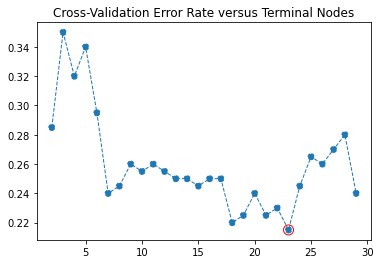

In [11]:
# plot the cross-validation error by terminal nodes
figure, axes = pyplot.subplots ()
axes.plot (range (0, 30), 1 - decisionTreeGrid.cv_results_["mean_test_score"], linestyle = "--", linewidth = 1)
axes.scatter (range (0, 30), 1 - decisionTreeGrid.cv_results_["mean_test_score"], linestyle = "--", linewidth = 1)
axes.set_title ("Cross-Validation Error Rate versus Terminal Nodes")

# plot the best performing set of terminal nodes
best_x = (cvResults [decisionTreeGrid.best_index_])[0]["max_leaf_nodes"]
best_y = 1 - (cvResults [decisionTreeGrid.best_index_])[1]
axes.scatter(best_x, best_y, s=100, linewidth=1, facecolors='none', edgecolors='r')


The plot shows the cross-validation error rate with the number of terminal nodes. The highlighted point is the lowest error rate at terminal nodes 19, which is selected for the best model.

The classification accuracy of the test set was 0.76 with using 19 terminal nodes.

In [12]:
# let's refit a tree with 28 terminal nodes (leaves) and look at the test error rate
# we cannot ensure the same shuffle for that node fit, but the error rate should be close
numpy.random.seed (3)

# hyperparameters (this is a require parameter on the GridSearchCV)
# let's limit the grid search to the 
hyperparameters = { "max_leaf_nodes": range (28, 29) } 
decisionTreeGrid: GridSearchCV = GridSearchCV (estimator = DecisionTreeClassifier (), param_grid = hyperparameters)
decisionTreeGrid.fit (trainX, trainy)
decisionTreeNodes = DecisionTreeSummary (decisionTreeGrid.best_estimator_, trainX, trainy, testX, testy)

# let's print out the mean cross validation error rate for each parameter tested
cvResults = numpy.column_stack ((decisionTreeGrid.cv_results_ ["params"], numpy.round (decisionTreeGrid.cv_results_ ["mean_test_score"], 4)))

# higher is better as the score is simply the classification rate
print ("Best cross-validation result: ")
print (cvResults [decisionTreeGrid.best_index_])

Classification tree: 
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=28,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Variables actually used in tree construction:
Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age',
       'Education', 'ShelveLoc_Good', 'ShelveLoc_Medium'],
      dtype='object')
Number of terminal nodes: 27
Residual mean deviance: 6.2747 = 1085.52 / 173
Misclassification error rate: 0.00

Test Error Classification Report
              precision    recall  f1-score   support

           0       0.81      0.71      0.76       122
           1       0.62      0.74      0.68        78

    accuracy                           0.7

The accuracy in the expanded terminal nodes decreased from the 0.76 in the best fit to 0.73. We have a larger tree with lower classification accuracy.